In [1]:
import pandas as pd
import plotly.express as px
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Загрузка данных
df = pd.read_csv('co2-ppm-daily.csv')
df['date'] = pd.to_datetime(df['date'])
print(df)

            date   value
0     1958-03-30  316.16
1     1958-03-31  316.40
2     1958-04-02  317.67
3     1958-04-03  317.76
4     1958-04-04  317.09
...          ...     ...
18759 2017-12-27  406.88
18760 2017-12-28  408.26
18761 2017-12-29  407.53
18762 2017-12-30  407.30
18763 2017-12-31  407.01

[18764 rows x 2 columns]


In [3]:
# Построение scatter-графика с помощью plotly
px.scatter(x=df['date'], y=df['value']).show()

In [4]:
# Преобразование данных для модели Prophet
df.rename(columns={'date': 'ds', 'value': 'y'}, inplace=True)
model_prophet = Prophet()
model_prophet.fit(df)

20:46:05 - cmdstanpy - INFO - Chain [1] start processing
20:46:21 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Создание прогноза на 365 дней
future_data = model_prophet.make_future_dataframe(periods=365)
forecast_data = model_prophet.predict(future_data)
print(forecast_data)

              ds       trend  yhat_lower  yhat_upper  trend_lower  \
0     1958-03-30  314.860405  316.029942  317.718889   314.860405   
1     1958-03-31  314.862829  316.060226  317.690335   314.862829   
2     1958-04-02  314.867675  316.176385  317.870263   314.867675   
3     1958-04-03  314.870099  316.183095  317.890379   314.870099   
4     1958-04-04  314.872522  316.234251  317.870800   314.872522   
...          ...         ...         ...         ...          ...   
19124 2018-12-27  409.017632  407.642443  409.506702   408.855099   
19125 2018-12-28  409.023747  407.678495  409.515062   408.859339   
19126 2018-12-29  409.029861  407.668213  409.506833   408.864549   
19127 2018-12-30  409.035976  407.775448  409.604749   408.869927   
19128 2018-12-31  409.042091  407.823057  409.622296   408.875304   

       trend_upper  additive_terms  additive_terms_lower  \
0       314.860405        2.000297              2.000297   
1       314.862829        2.028770              2.0

c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\1\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\

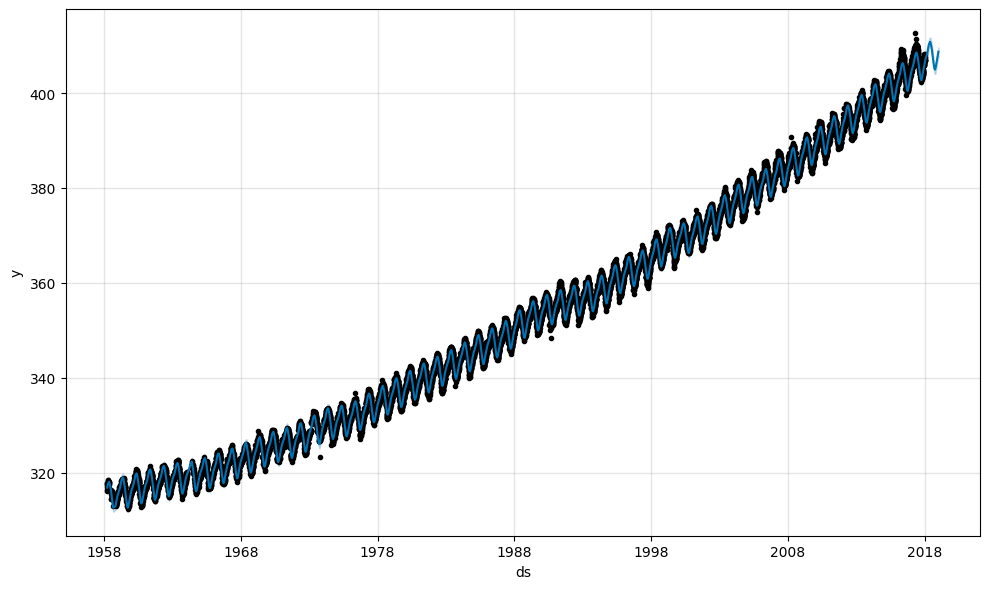

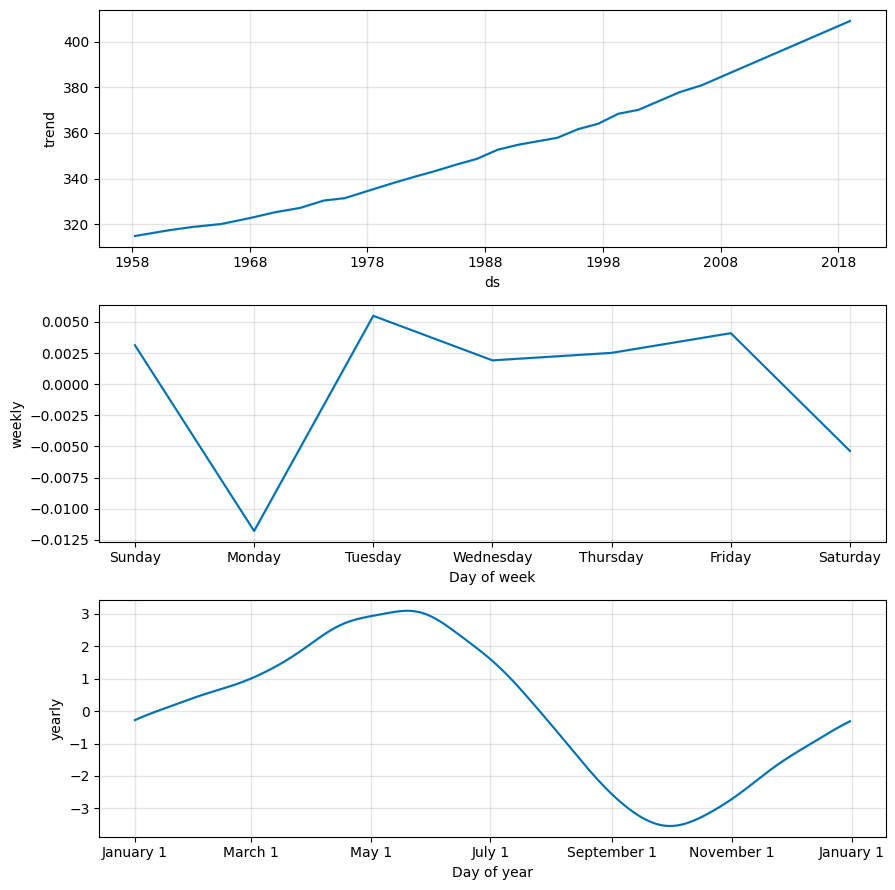

In [6]:
# Построение графиков прогноза
model_prophet.plot(forecast_data)
model_prophet.plot_components(forecast_data)

# Копирование данных для дальнейшей работы
data = df.copy()

              ds        yhat  yhat_lower  yhat_upper
19489 2019-12-27  410.798982  409.569780  411.996345
19490 2019-12-28  410.828165  409.701266  411.958442
19491 2019-12-29  410.874551  409.696938  412.057150
19492 2019-12-30  410.896763  409.727758  412.051484
19493 2019-12-31  410.950344  409.709992  412.054992


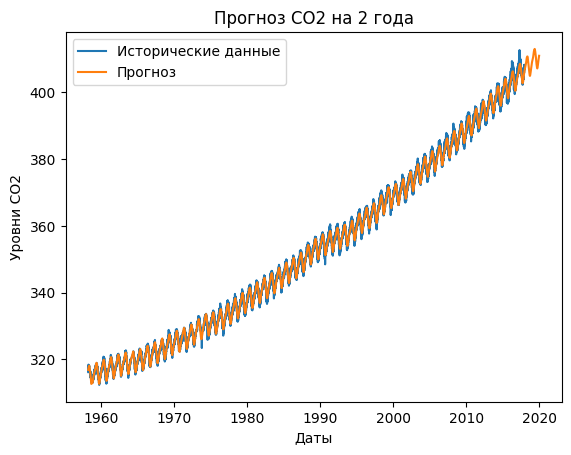

In [7]:
# Прогноз на 2 года вперед
future_two_years = model_prophet.make_future_dataframe(periods=730)
forecast_two_years = model_prophet.predict(future_two_years)
print(forecast_two_years[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Построение графика 
plt.plot(df['ds'], df['y'], label='Исторические данные')
plt.plot(forecast_two_years['ds'], forecast_two_years['yhat'], label='Прогноз')
plt.xlabel('Даты')
plt.ylabel('Уровни CO2')
plt.title('Прогноз CO2 на 2 года')
plt.legend()
plt.show()

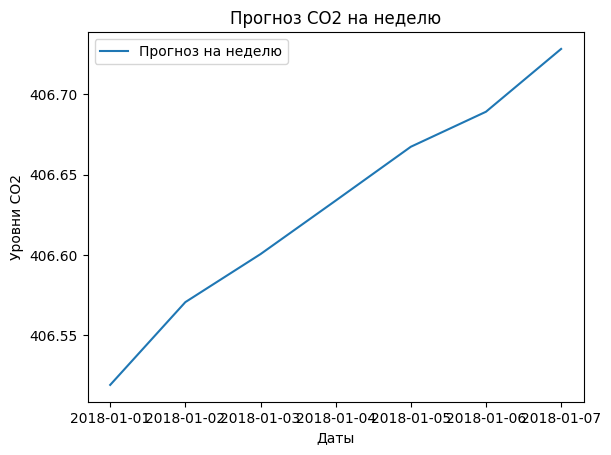

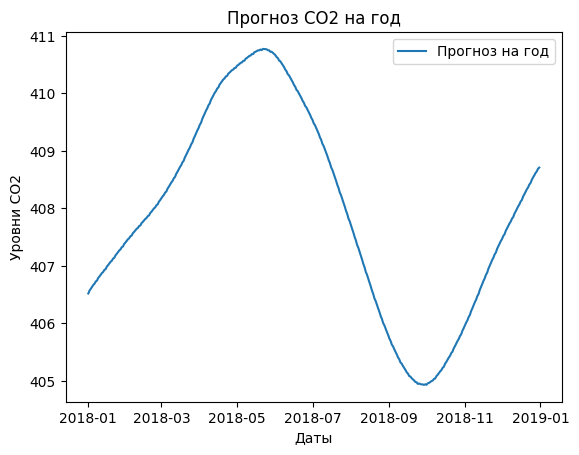

In [9]:
# Прогноз на неделю
week_prediction = forecast_two_years[(forecast_two_years['ds'] > df['ds'].max()) & (forecast_two_years['ds'] <= df['ds'].max() + pd.Timedelta(days=7))]
plt.plot(week_prediction['ds'], week_prediction['yhat'], label='Прогноз на неделю')
plt.xlabel('Даты')
plt.ylabel('Уровни CO2')
plt.title('Прогноз CO2 на неделю')
plt.legend()
plt.show()

# Прогноз на год
year_prediction = forecast_two_years[(forecast_two_years['ds'] > df['ds'].max()) & (forecast_two_years['ds'] <= df['ds'].max() + pd.Timedelta(days=365))]
plt.plot(year_prediction['ds'], year_prediction['yhat'], label='Прогноз на год')
plt.xlabel('Даты')
plt.ylabel('Уровни CO2')
plt.title('Прогноз CO2 на год')
plt.legend()
plt.show()


In [12]:
# Подготовка данных для моделей машинного обучения
data_ml = data.copy()
data_ml['ordinal_date'] = data_ml['ds'].map(lambda x: x.toordinal())

features = data_ml[['ordinal_date']]
target = data_ml['y']

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=42)

In [13]:
# Создание DataFrame с датами для тестовой выборки
test_features_with_ds = test_features.copy()
test_features_with_ds['ds'] = test_features_with_ds['ordinal_date'].map(lambda x: pd.Timestamp.fromordinal(x))
prophet_predictions = forecast_two_years[forecast_two_years['ds'].isin(test_features_with_ds['ds'])]['yhat']

In [14]:
# Обучение модели случайного леса для регрессии
forest_model = RandomForestRegressor(n_estimators=100)
forest_model.fit(train_features, train_target)
forest_predictions = forest_model.predict(test_features)

In [15]:
# Обучение модели линейной регрессии
linear_model = LinearRegression()
linear_model.fit(train_features, train_target)
linear_predictions = linear_model.predict(test_features)

In [16]:
# Прогноз на будущее
future_dates = pd.date_range(start=df['ds'].max(), periods=730).to_frame(index=False, name='ds')
future_dates['ordinal_date'] = future_dates['ds'].map(lambda x: x.toordinal())

forest_future_pred = forest_model.predict(future_dates[['ordinal_date']])
linear_future_pred = linear_model.predict(future_dates[['ordinal_date']])
prophet_future_pred = forecast_two_years[forecast_two_years['ds'].isin(future_dates['ds'])]['yhat']

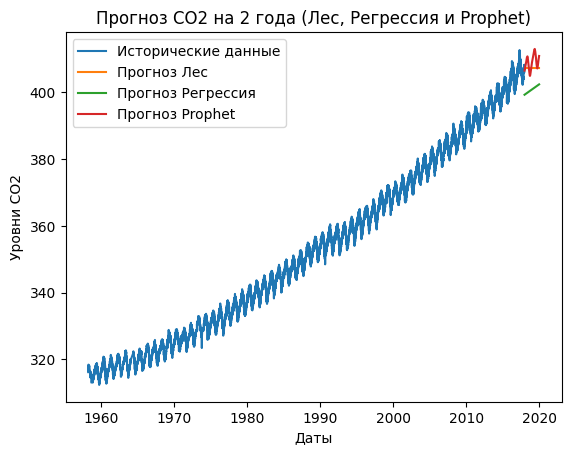

In [17]:
# Построение графика с прогнозами
plt.plot(data['ds'], data['y'], label='Исторические данные')
plt.plot(future_dates['ds'], forest_future_pred, label='Прогноз Лес')
plt.plot(future_dates['ds'], linear_future_pred, label='Прогноз Регрессия')
plt.plot(future_dates['ds'], prophet_future_pred, label='Прогноз Prophet')
plt.xlabel('Даты')
plt.ylabel('Уровни CO2')
plt.title('Прогноз CO2 на 2 года (Лес, Регрессия и Prophet)')
plt.legend()
plt.show()

In [18]:
# Вычисление ошибок
prophet_error = np.mean((prophet_predictions.values - test_target.values)**2)
forest_error = np.mean((forest_predictions - test_target)**2)
linear_error = np.mean((linear_predictions - test_target)**2)

print(f'Ошибка Prophet: {prophet_error}')
print(f'Ошибка Лес: {forest_error}')
print(f'Ошибка Регрессия: {linear_error}')

if prophet_error < forest_error and prophet_error < linear_error:
    print("Модель Prophet лучше.")
elif forest_error < linear_error:
    print("Модель случайного леса лучше.")
else:
    print("Модель линейной регрессии лучше.")

Ошибка Prophet: 1339.1003902428222
Ошибка Лес: 0.20668640556088563
Ошибка Регрессия: 15.474328273570093
Модель случайного леса лучше.
